<a href="https://colab.research.google.com/github/elijahkinghernandez/Final-Project/blob/main/Copy_of_houseMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA COLLECTION AND CLEANING

In [1]:
import pandas as pd

In [2]:
# Read in csv file with member names
H117_members = pd.read_csv("/content/H117_members.csv")

# Create a datframe with only LA county representatives

desired = 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 43, 44, 47, 48
la_list = []

for i in desired:
  la = H117_members[H117_members['district_code'] == i][H117_members['state_abbrev'] == 'CA']
  la_list.append(la) 
la_reps = pd.concat(la_list)

# Filter for desired columns
la_reps = la_reps[['icpsr', 'bioname', 'district_code', 'party_code', 'born', 'nominate_dim1']]
la_reps = la_reps.rename(columns={'nominate_dim1': 'economic lib-con'})

<ipython-input-2-0c9c73bc0ee1>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  la = H117_members[H117_members['district_code'] == i][H117_members['state_abbrev'] == 'CA']


In [3]:
# Read in csv file with rollcalls-- items being put up to a vote
H117_rollcalls = pd.read_csv("/content/H117_rollcalls.csv")

# Filter for desired columns
H117_rollcalls = H117_rollcalls[['rollnumber', 'vote_desc', 'vote_question', 'vote_result', 'date', 'yea_count', 'nay_count']]

In [4]:
# Read in csv file indicating how each congressperson voted on each rollcall
H117_votes = pd.read_csv("/content/H117_votes.csv")

# Filter for desired columns
H117_votes = H117_votes[['rollnumber', 'icpsr', 'cast_code', 'prob']]

In [5]:
# Read in csv file indicating la_reps demographics; had to make this myself
la_reps_demographics = pd.read_csv('/content/H117 - demographics - 1.csv')

# Filter for desired columns
la_reps_demographics = la_reps_demographics[['icpsr', 'gender', 'race', 'immigrant']]

In [6]:
# Merge h117_votes with la_reps on each congressperson's unique id
votes_la_reps = H117_votes.merge(la_reps, on=["icpsr"], how="inner")

In [7]:
# All three csv files now merged 
la_votesMembersDescriptions = votes_la_reps.merge(H117_rollcalls, on=["rollnumber"], how="inner")

# Make vote reult a binary-- passed/failed --> 1/0
la_votesMembersDescriptions = la_votesMembersDescriptions[la_votesMembersDescriptions['vote_result'] != 'Pelosi']
la_votesMembersDescriptions = la_votesMembersDescriptions[la_votesMembersDescriptions['vote_result'] != 'Agreed to']
la_votesMembersDescriptions['vote_result'] = la_votesMembersDescriptions['vote_result'].replace('Passed', 1).replace('Failed', 0)

In [8]:
# Final dataframe to be used in machine learning model
df = la_votesMembersDescriptions.merge(la_reps_demographics, on=["icpsr"], how="outer")

In [9]:
# Filter for only yea or nay votes and cast as 0/1
df = df[df['cast_code'] != 7]
df = df[df['cast_code'] != 9]
df['cast_code'] = df['cast_code'].replace(6, 'nay')
df['cast_code'] = df['cast_code'].replace(1, 'yea')
df['cast_code'].value_counts()

# Cast female/male as 0/1
df['gender'] = df['gender'].replace('female', 0)
df['gender'] = df['gender'].replace('male', 1)

# Cast immigrant/not immigrant as 1/0
df['immigrant'] = df['immigrant'].replace('no', 0)
df['immigrant'] = df['immigrant'].replace('yes', 1)

# Turn born column into age column when congressperson was elected 
df['born'] = 2020 - df['born']
df = df.rename(columns={'born': 'age elected'})

In [10]:
df_ml = df[df['vote_desc'].notna()]

In [11]:
df_ml

,rollnumber,icpsr,cast_code,prob,bioname,district_code,party_code,age elected,economic lib-con,vote_desc,vote_question,vote_result,date,yea_count,nay_count,gender,race,immigrant
1,3,20104.0,yea,100.0,"SCHIFF, Adam",28,100,60,-0.350,Adopting the Rules of the House of Representat...,On Motion to Table the Motion to Postpone to a...,1,2021-01-04,214,204,1,white,0
2,4,20104.0,yea,100.0,"SCHIFF, Adam",28,100,60,-0.350,Adopting the Rules of the House of Representat...,Table Motion to Refer,1,2021-01-04,214,196,1,white,0
3,5,20104.0,yea,100.0,"SCHIFF, Adam",28,100,60,-0.350,Adopting the Rules of the House of Representat...,On Ordering the Previous Question,1,2021-01-04,217,204,1,white,0
4,6,20104.0,nay,100.0,"SCHIFF, Adam",28,100,60,-0.350,Adopting the Rules of the House of Representat...,On Motion to Commit with Instructions,0,2021-01-04,203,217,1,white,0
5,7,20104.0,yea,100.0,"SCHIFF, Adam",28,100,60,-0.350,Adopting the Rules of the House of Representat...,On Agreeing to the Resolution,1,2021-01-04,217,206,1,white,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16511,991,29903.0,yea,100.0,"NAPOLITANO, Grace Flores",32,100,84,-0.448,Native American Langauge Resource Center Act o...,On Motion to Suspend the Rules and Pass,1,2022-12-22,342,71,0,hispanic,0
16512,992,29903.0,yea,100.0,"NAPOLITANO, Grace Flores",32,100,84,-0.448,Durbin Feeling Native American Languages Act o...,On Motion to Suspend the Rules and Pass,1,2022-12-22,337,79,0,hispanic,0
16513,993,29903.0,yea,99.8,"NAPOLITANO, Grace Flores",32,100,84,-0.448,Student Veteran Emergency Relief Act,On Motion to Suspend the Rules and Concur in t...,1,2022-12-22,380,35,0,hispanic,0
16514,994,29903.0,yea,100.0,"NAPOLITANO, Grace Flores",32,100,84,-0.448,Providing for consideration of the Senate amen...,On Agreeing to the Resolution,1,2022-12-23,215,206,0,hispanic,0


DATA EXPLORATION / VISUALIZATIONS

<Axes: title={'center': 'PARTY DISTRIBUTION'}, xlabel='party'>

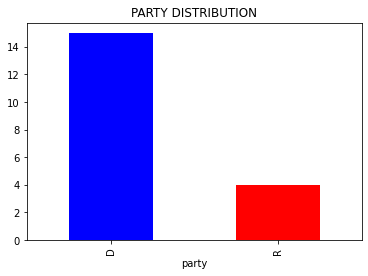

In [12]:
# PARTY DISTRIBUTION VISUALIZATION

one = la_reps['party_code'].value_counts()
one = pd.DataFrame(one)
one = one.reset_index()
one = one.rename(columns={'index': 'party', 'party_code': '# of reps'})
one = one.replace(100, 'D')
one = one.replace(200, 'R')
one.plot.bar(x='party', y='# of reps', color=['blue', 'red'], legend=False, title='PARTY DISTRIBUTION')

<Axes: title={'center': 'YEA/NAY VOTE DISTRIBUTIONS'}, xlabel='cast'>

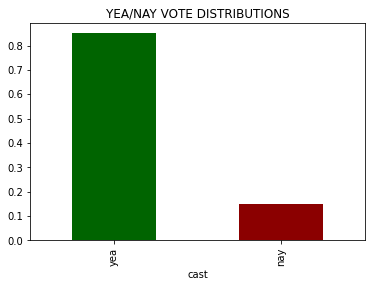

In [13]:
# YEA/NAY VOTE DISTRIBUTIONS

yn_count = ((pd.DataFrame(df_ml['cast_code'].value_counts(normalize=True))).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
yn_count.plot.bar(x='cast', y='count', color=['darkgreen', 'darkred'], title='YEA/NAY VOTE DISTRIBUTIONS', legend=False)


<Axes: title={'center': 'YEA/NAY VOTE DISTRIBUTIONS BY PARTY'}, xlabel='cast'>

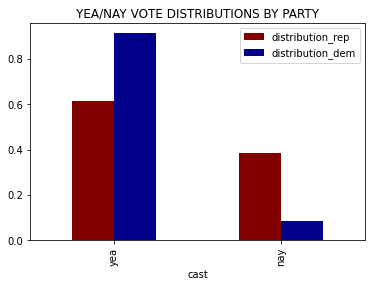

In [14]:
# YEA/NAY VOTE DISTRIBUTIONS BY PARTY

dems = df_ml[df_ml['party_code'] == 100]
dems_count = ((pd.DataFrame(dems['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
dems_count['total'] = dems_count['count'].sum()
dems_count['distribution'] = dems_count['count'] / dems_count['total']
dems_count = dems_count[['cast', 'distribution']]

reps = df_ml[df_ml['party_code'] == 200]
rep_count = ((pd.DataFrame(reps['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
rep_count['total'] = rep_count['count'].sum()
rep_count['distribution'] = rep_count['count'] / rep_count['total']
rep_count = rep_count[['cast', 'distribution']]

dem_rep_yn_count = rep_count.merge(dems_count, on=['cast'], how="inner", suffixes=('_rep', '_dem'))
dem_rep_yn_count.plot.bar(x='cast', title='YEA/NAY VOTE DISTRIBUTIONS BY PARTY', color=['maroon', 'darkblue'])

In [15]:
# NEEDED TO CLEAN RACE COLUMN-- hispanic was separated because of a trailing space 
df_ml['race'] = df_ml['race'].replace('hispanic ', 'hispanic')

<ipython-input-15-14fe5f6ef3c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['race'] = df_ml['race'].replace('hispanic ', 'hispanic')


<Axes: title={'center': 'YEA/NAY VOTE DISTRIBUTIONS BY RACE'}, xlabel='cast'>

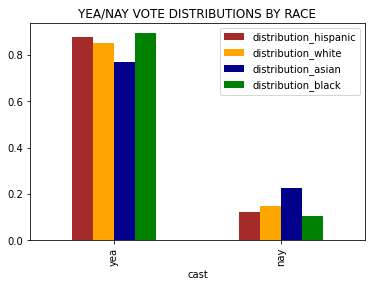

In [16]:
# YEA/NAY VOTE DISTRIBUTIONS BY RACE

hispanic = df_ml[df_ml['race'] == 'hispanic']
hispanic_count = ((pd.DataFrame(hispanic['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
hispanic_count['total'] = hispanic_count['count'].sum()
hispanic_count['distribution'] = hispanic_count['count'] / hispanic_count['total']
hispanic_count = hispanic_count[['cast', 'distribution']]

white = df_ml[df_ml['race'] == 'white']
white_count = ((pd.DataFrame(white['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
white_count['total'] = white_count['count'].sum()
white_count['distribution'] = white_count['count'] / white_count['total']
white_count = white_count[['cast', 'distribution']]

asian = df_ml[df_ml['race'] == 'asian']
asian_count = ((pd.DataFrame(asian['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
asian_count['total'] = asian_count['count'].sum()
asian_count['distribution'] = asian_count['count'] / asian_count['total']
asian_count = asian_count[['cast', 'distribution']]

black = df_ml[df_ml['race'] == 'black']
black_count = ((pd.DataFrame(black['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
black_count['total'] = black_count['count'].sum()
black_count['distribution'] = black_count['count'] / black_count['total']
black_count = black_count[['cast', 'distribution']]

his_wh_yn_count = hispanic_count.merge(white_count, on=['cast'], how="inner", suffixes=('_hispanic', '_white'))
as_bl_yn_count = asian_count.merge(black_count, on=['cast'], how="inner", suffixes=('_asian', '_black'))

comb_race_yn_count = his_wh_yn_count.merge(as_bl_yn_count, on=['cast'], how="inner", suffixes=('_asian', '_black'))
comb_race_yn_count.plot.bar(x='cast', title='YEA/NAY VOTE DISTRIBUTIONS BY RACE', color=['brown', 'orange', 'darkblue', 'green'])


<Axes: title={'center': 'YEA/NAY VOTE DISTRIBUTIONS BY GENDER'}, xlabel='cast'>

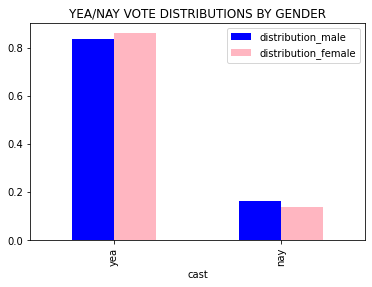

In [17]:
# YEA/NAY VOTE DISTRIBUTIONS BY GENDER

female = df_ml[df_ml['gender'] == 0]
female_count = ((pd.DataFrame(female['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
female_count['total'] = female_count['count'].sum()
female_count['distribution'] = female_count['count'] / female_count['total']
female_count = female_count[['cast', 'distribution']]

male = df_ml[df_ml['gender'] == 1]
male_count = ((pd.DataFrame(male['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
male_count['total'] = male_count['count'].sum()
male_count['distribution'] = male_count['count'] / male_count['total']
male_count = male_count[['cast', 'distribution']]

gender_yn_count = male_count.merge(female_count, on=['cast'], how="inner", suffixes=('_male', '_female'))
gender_yn_count.plot.bar(x='cast', title='YEA/NAY VOTE DISTRIBUTIONS BY GENDER', color=['blue', 'lightpink'])

<Axes: title={'center': 'YEA/NAY VOTE DISTRIBUTIONS BY IMMIGRANT'}, xlabel='cast'>

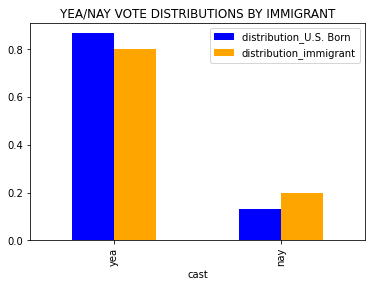

In [18]:
# YEA/NAY VOTE DISTRIBUTIONS BY IMMIGRANT

usBorn = df_ml[df_ml['immigrant'] == 0]
usBorn_count = ((pd.DataFrame(usBorn['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
usBorn_count['total'] = usBorn_count['count'].sum()
usBorn_count['distribution'] = usBorn_count['count'] / usBorn_count['total']
usBorn_count = usBorn_count[['cast', 'distribution']]

immigrant = df_ml[df_ml['immigrant'] == 1]
immigrant_count = ((pd.DataFrame(immigrant['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
immigrant_count['total'] = immigrant_count['count'].sum()
immigrant_count['distribution'] = immigrant_count['count'] / immigrant_count['total']
immigrant_count = immigrant_count[['cast', 'distribution']]

immigrant_yn_count = usBorn_count.merge(immigrant_count, on=['cast'], how="inner", suffixes=('_U.S. Born', '_immigrant'))
immigrant_yn_count.plot.bar(x='cast', title='YEA/NAY VOTE DISTRIBUTIONS BY IMMIGRANT', color=['blue', 'orange'])

44    1515
46     758
51    1514
55    1484
57     757
58     758
60     761
65     755
66     759
67    1480
68     755
79    1518
82     744
84     761
Name: age elected, dtype: int64


<Axes: title={'center': 'YEA/NAY VOTE DISTRIBUTIONS BY AGE GROUP'}, xlabel='cast'>

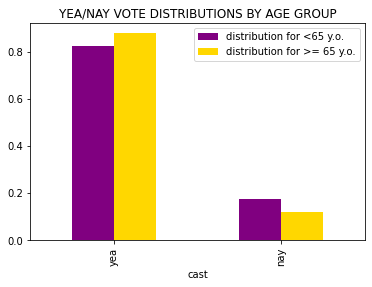

In [19]:
# YEA/NAY VOTE DISTRIBUTIONS BY AGE GROUP-- separated into working age (<65) and elderly (>=65)

print(df_ml['age elected'].value_counts().sort_index())

id_name_age = df_ml[['icpsr', 'bioname', 'age elected']]
id_name_age_noDupes = id_name_age.drop_duplicates()
id_name_age_noDupes

elderly = df_ml[df_ml['age elected'] >= 65]
elderly_count = ((pd.DataFrame(elderly['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
elderly_count['total'] = elderly_count['count'].sum()
elderly_count['distribution'] = elderly_count['count'] / elderly_count['total']
elderly_count = elderly_count[['cast', 'distribution']]

working_age = df_ml[df_ml['age elected'] < 65]
working_age_count = ((pd.DataFrame(working_age['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
working_age_count['total'] = working_age_count['count'].sum()
working_age_count['distribution'] = working_age_count['count'] / working_age_count['total']
working_age_count = working_age_count[['cast', 'distribution']]

age_yn_count = working_age_count.merge(elderly_count, on=['cast'], how="inner", suffixes=(' for <65 y.o.', ' for >= 65 y.o.'))
age_yn_count.plot.bar(x='cast', title='YEA/NAY VOTE DISTRIBUTIONS BY AGE GROUP', color=['purple', 'gold'])

<Axes: title={'center': 'YEA/NAY VOTE DISTRIBUTIONS BY ECONOMIC LIB/CON SCORE'}, xlabel='cast'>

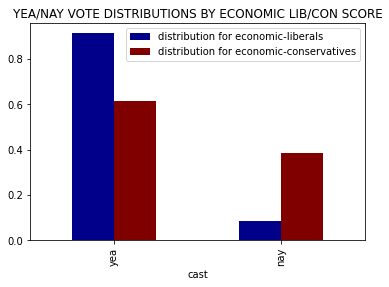

In [20]:
# YEA/NAY VOTE DISTRIBUTIONS BY IMMIGRANT AGE GROUP-- separated into working age (<65) and elderly (>=65)

conservative = df_ml[df_ml['economic lib-con'] > 0]
conservative_count = ((pd.DataFrame(conservative['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
conservative_count['total'] = conservative_count['count'].sum()
conservative_count['distribution'] = conservative_count['count'] / conservative_count['total']
conservative_count = conservative_count[['cast', 'distribution']]

liberal = df_ml[df_ml['economic lib-con'] < 0]
liberal_count = ((pd.DataFrame(liberal['cast_code'].value_counts())).reset_index()).rename(columns={'index': 'cast', 'cast_code': 'count'})
liberal_count['total'] = liberal_count['count'].sum()
liberal_count['distribution'] = liberal_count['count'] / liberal_count['total']
liberal_count = liberal_count[['cast', 'distribution']]

conlib_yn_count = liberal_count.merge(conservative_count, on=['cast'], how="inner", suffixes=(' for economic-liberals', ' for economic-conservatives'))
conlib_yn_count.plot.bar(x='cast', title='YEA/NAY VOTE DISTRIBUTIONS BY ECONOMIC LIB/CON SCORE', color=['darkblue', 'maroon'])

This looks very similar-- if not the same-- as the distribution plot by party.

MACHINE LEARNING

In [21]:
# COMPARISON OF SEVERAL DIFFERENT MODELS-- X_train arguments differ

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer

preproc = [(TfidfVectorizer(max_features=100), 'vote_desc'),
           (TfidfVectorizer(max_features=100), 'vote_question'),
           (StandardScaler(), ['party_code']),
           (StandardScaler(), ['economic lib-con']),
           (StandardScaler(), ['age elected']),
           (StandardScaler(), ['gender']),
           (StandardScaler(), ['immigrant']),
           (OneHotEncoder(), ['race'])
           ]

features = ['vote_desc', 'vote_question', 'party_code', 'economic lib-con', 'age elected', 'gender', 'immigrant', 'race']

X_train = df_ml[['vote_desc', 'vote_question', 'party_code', 'economic lib-con', 'age elected', 'gender', 'immigrant', 'race']]
y_train = df_ml['cast_code']
scores=[]

for feature in range(1, len(preproc) + 1):
  pipeline = make_pipeline(make_column_transformer(
      *preproc[: feature],
      remainder='drop'),
      KNeighborsClassifier(n_neighbors = 5,
                           metric='euclidean'))

  scores.append(cross_val_score(pipeline,
                            X_train,
                            y_train,
                            scoring='accuracy',
                            cv=10).mean())

[0.8433558202452479, 0.8935050985949584, 0.981284428203897, 0.9790498889318326, 0.9690637578128356, 0.9509767752362883, 0.8671081089522114, 0.7951051438811005]
0    0.981284
dtype: float64


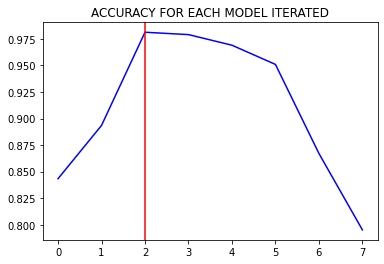

In [22]:
# VISUALIZATION FOR WHAT X ARGS CREATE MOST ACCURATE MODEL

print(scores)
x_args = pd.DataFrame(scores)
acc_plot = x_args.plot(title="ACCURACY FOR EACH MODEL ITERATED", legend=False, color='blue')
print(x_args.max())
acc_plot.axvline(x=2, color='red')

In [23]:
# PRINTING ARGUMENTS FOR OPTIMAL ACCURACY

import numpy as np

model_indices = np.argmax(np.asarray((scores)), axis=0)+1
features[:model_indices]

['vote_desc', 'vote_question', 'party_code']

Best x_train arguments are 'vote_desc', 'vote_question', and 'party_code'.

In [24]:
# OPTIMAL X INPUT MACHINE LEARNING MODEL

X_train = df_ml[['vote_desc', 'vote_question', 'party_code']]
y_train = df_ml['cast_code']

final_model = make_pipeline(make_column_transformer((TfidfVectorizer(max_features=100), 'vote_desc'),
                                                    (TfidfVectorizer(max_features=100), 'vote_question'),
                                                    (StandardScaler(), ['party_code'])),
                                                    KNeighborsClassifier(n_neighbors = 3,
                                                                         metric='manhattan'))

cross_val_score(final_model, X_train, y_train,
                scoring="accuracy", cv=10).mean()

0.983588799878196

In [25]:
# HYPERPARAMETER TESTING K VALUES AND DISTANCE METRIC

from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(
    final_model,
    param_grid={
        "kneighborsclassifier__n_neighbors": range(1, 10),
        "kneighborsclassifier__metric": ["euclidean", "manhattan"],
        },
        scoring="accuracy", cv=10)

grid_cv.fit(X_train, y_train)
grid_cv.best_params_

{'kneighborsclassifier__metric': 'manhattan',
 'kneighborsclassifier__n_neighbors': 3}

2^8 a lot of processing time

FINAL MACHINE LEARNING MODEL

In [26]:
from sklearn.metrics import accuracy_score

# ESTIMATING TEST ERROR

vote_train = df_ml[['vote_desc', 'vote_question', 'party_code', 'cast_code']]
train = vote_train.sample(frac=.5)
val = vote_train.drop(train.index)

X_train = train[['vote_desc', 'vote_question', 'party_code']]
y_train = train['cast_code']

# validation set 
X_val = val[['vote_desc', 'vote_question', 'party_code']]
y_val = val['cast_code']

final_model = make_pipeline(make_column_transformer((TfidfVectorizer(max_features=100), 'vote_desc'),
                                                    (TfidfVectorizer(max_features=100), 'vote_question'),
                                                    (StandardScaler(), ['party_code'])),
                                                    KNeighborsClassifier(n_neighbors = 3,
                                                                         metric='manhattan'))

# test error 
final_model.fit(X_train, y_train)
y_val_ = final_model.predict(X_val)
accuracy_score(y_val, y_val_)

0.9692694510406481

In [27]:
# CROSS VALIDATION

cross_val_score(final_model,
                X=df_ml[['vote_desc', 'vote_question', 'party_code']],
                y=df_ml['cast_code'],
                scoring="accuracy", cv=10).mean()

0.983588799878196

In [30]:
# CONFUSION MATRIX-- make sure to do this on the test set not train set 

from sklearn.metrics import confusion_matrix

y_train.value_counts()
final_model.fit(X_train, y_train)
y_train_ = final_model.predict(X_train)

confusion_matrix(y_train, y_train_)

array([[1000,  102],
       [  26, 6032]])

**PRECISION: TP / (TP + FP)** *go back and combine these should not be separated*

*YES*: 12111 / (12111 + 118) = 12111 / 12229 = **0.99035081**

*NO*: 2028 / (2028 + 62) = 2028 / 2090 = **0.97033493**

**RECALL: TP / (TP + FN)**

*YES*: 12111 / (12111 + 62) = 12111 / 12173 = **0.99490676**

*NO*: 2028 / (2028 + 118) = 2028 / 2146 = **0.94501398**